In [2]:
import sys
import math
import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model


models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [3]:
import torch
import math

def _compute_batch_log_ratios(samples: torch.Tensor, subs_size: int, log_score_fn: callable) -> torch.Tensor:
    """
    Helper: Computes the raw log likelihood ratios log(P_swap / P_ref) for a single batch.
    """
    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0:
        return torch.tensor([], device=samples.device)

    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]

    # Calculate scores for reference (original) configuration
    with torch.no_grad():
        ref_1_score = log_score_fn(ref_1)
        ref_2_score = log_score_fn(ref_2)

        # Create Swapped versions
        slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

        swap_1 = ref_1.clone()
        swap_1[:, slice_idx] = ref_2[:, slice_idx]
        swap_2 = ref_2.clone()
        swap_2[:, slice_idx] = ref_1[:, slice_idx]

        swap_1_score = log_score_fn(swap_1)
        swap_2_score = log_score_fn(swap_2)

    # Log ratio: log(P(swap)) - log(P(ref))
    # This represents log(e^{score_swap} / e^{score_ref})
    # Shape: (batch_size // 2, )
    log_ratios = (swap_1_score + swap_2_score) - (ref_1_score + ref_2_score)

    return log_ratios

def estimate_entropy_naive_swap(samples: torch.Tensor,
                                subs_size: int,
                                log_score_fn: callable,
                                batch_size: int = 10_000) -> tuple:
    """
    Computes Renyi Entropy (S2) using the Naive Swap test with proper error propagation.

    It accumulates the moments of the likelihood ratios (R) globally to avoid
    Jensen's inequality bias, and uses the Delta Method to estimate the standard error of S2.

    Returns:
        mean_entropy (float): The estimated S2.
        std_error (float): The standard error of the estimate (Delta Method).
    """
    n_total = samples.shape[0]
    if n_total < 2:
        return float("nan"), 0.0

    # Accumulators for moments of Ratio R = exp(log_ratio)
    # stored in log-space to prevent overflow/underflow
    total_log_sum_r = torch.tensor(-float('inf'), device=samples.device)    # log(Sum(R))
    total_log_sum_sq_r = torch.tensor(-float('inf'), device=samples.device) # log(Sum(R^2))

    total_pairs = 0

    # 1. Iterate over batches
    for start in range(0, n_total, batch_size):
        end = min(start + batch_size, n_total)
        if end - start < 2:
            continue

        batch_samples = samples[start:end]

        # Get raw log ratios for this batch
        batch_log_ratios = _compute_batch_log_ratios(batch_samples, subs_size, log_score_fn)

        if batch_log_ratios.numel() == 0:
            continue

        total_pairs += batch_log_ratios.numel()

        # Update First Moment: Sum(R)
        # log(current + batch) = logaddexp(log_current, log_batch)
        batch_log_sum = torch.logsumexp(batch_log_ratios, dim=0)
        total_log_sum_r = torch.logaddexp(total_log_sum_r, batch_log_sum)

        # Update Second Moment: Sum(R^2)
        # log(R^2) = 2 * log(R)
        batch_log_sum_sq = torch.logsumexp(2 * batch_log_ratios, dim=0)
        total_log_sum_sq_r = torch.logaddexp(total_log_sum_sq_r, batch_log_sum_sq)

    if total_pairs == 0:
        return float("nan"), 0.0

    # 2. Compute Global Statistics (Mean and Variance of the Ratio R)

    # Mean(R)
    log_mean_r = total_log_sum_r - math.log(total_pairs)
    mean_r = torch.exp(log_mean_r).item()

    # Mean(R^2)
    log_mean_sq_r = total_log_sum_sq_r - math.log(total_pairs)
    mean_sq_r = torch.exp(log_mean_sq_r).item()

    # 3. Compute Entropy
    # S2 = -log(Mean(R))
    renyi_entropy = -log_mean_r.item()

    # 4. Compute Error Bars (Delta Method)
    # Var(R) = E[R^2] - (E[R])^2
    var_r = mean_sq_r - (mean_r ** 2)

    # Float precision guard
    var_r = max(0.0, var_r)

    # Standard Error of the Mean Ratio: SE_R = sqrt(Var(R) / N_pairs)
    se_r = math.sqrt(var_r / total_pairs)

    # Propagate error through the logarithm: S2 = -log(R)
    # Error_S2 = |d/dR (-log R)| * Error_R = (1/R) * SE_R
    if mean_r > 0:
        entropy_err = se_r / mean_r
    else:
        entropy_err = float("inf")

    return renyi_entropy, entropy_err

In [4]:
model_filename = "hyprbm_tfim_16_20000_20260118_193918.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

model, config = load_model(model_path, device)

CHAIN_LENGTH = int(model.num_v)
h_support_vals = sorted(config.get("h_support", []))
print(f"Trained on support points: {h_support_vals} \n")

ref_file = Path(f"tfim_{CHAIN_LENGTH}_entangle_ref.csv")
ref_df = pd.read_csv(ref_file)
print(f"Loaded ED reference data from: {ref_file.name}")

Loading checkpoint: hyprbm_tfim_16_20000_20260118_193918.pt
Trained on support points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5] 

Loaded ED reference data from: tfim_16_entangle_ref.csv


In [20]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

ANNEAL_STEPS = 20

TOTAL_SAMPLES = 100_000
BATCH_SIZE = 10_000
DENSE_RES = 0.05


h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, DENSE_RES)
h_novel_vals = [h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)]
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

print(f"Sweeping h on dense grid: [{min(all_h_values):.2f}, {max(all_h_values):.2f}] | step={DENSE_RES}")
print(f"TOTAL_SAMPLES={TOTAL_SAMPLES} | BATCH_SIZE={BATCH_SIZE}")

results_list = []
l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))

rng_eval = torch.Generator(device=device).manual_seed(SEED)
model_dtype = next(model.parameters()).dtype

for h_val in all_h_values:
    split = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "interpolated"
    print(f"h={h_val:.2f} ({split:12})")

    cond_batch = torch.full((TOTAL_SAMPLES, 1), h_val, device=device, dtype=model_dtype)

    # use constant schedule of T=1.0 for generation
    schedule = torch.tensor([1.0] * ANNEAL_STEPS, device=device, dtype=model_dtype)
    with torch.no_grad():
        samples = model.generate(cond_batch, schedule, rng=rng_eval)

    def scorer(v):
        # prime scoring function with h_val
        c = torch.full((v.shape[0], 1), h_val, device=v.device, dtype=v.dtype)
        return model.log_score(v, c)

    for l in l_axis:
        # Call the new function here
        s2_mean, s2_err = estimate_entropy_naive_swap(samples, l, scorer, batch_size=BATCH_SIZE)
        results_list.append({"h": float(h_val), "l": int(l), "s2": s2_mean, "s2_err": s2_err, "type": split})

results_df = pd.DataFrame(results_list)

Sweeping h on dense grid: [0.50, 1.50] | step=0.05
TOTAL_SAMPLES=100000 | BATCH_SIZE=10000
h=0.50 (support     )
h=0.55 (interpolated)
h=0.60 (interpolated)
h=0.65 (interpolated)
h=0.70 (interpolated)
h=0.75 (interpolated)
h=0.80 (support     )
h=0.85 (interpolated)
h=0.90 (interpolated)
h=0.95 (support     )
h=1.00 (support     )
h=1.05 (support     )
h=1.10 (interpolated)
h=1.15 (interpolated)
h=1.20 (support     )
h=1.25 (interpolated)
h=1.30 (interpolated)
h=1.35 (interpolated)
h=1.40 (interpolated)
h=1.45 (interpolated)
h=1.50 (support     )


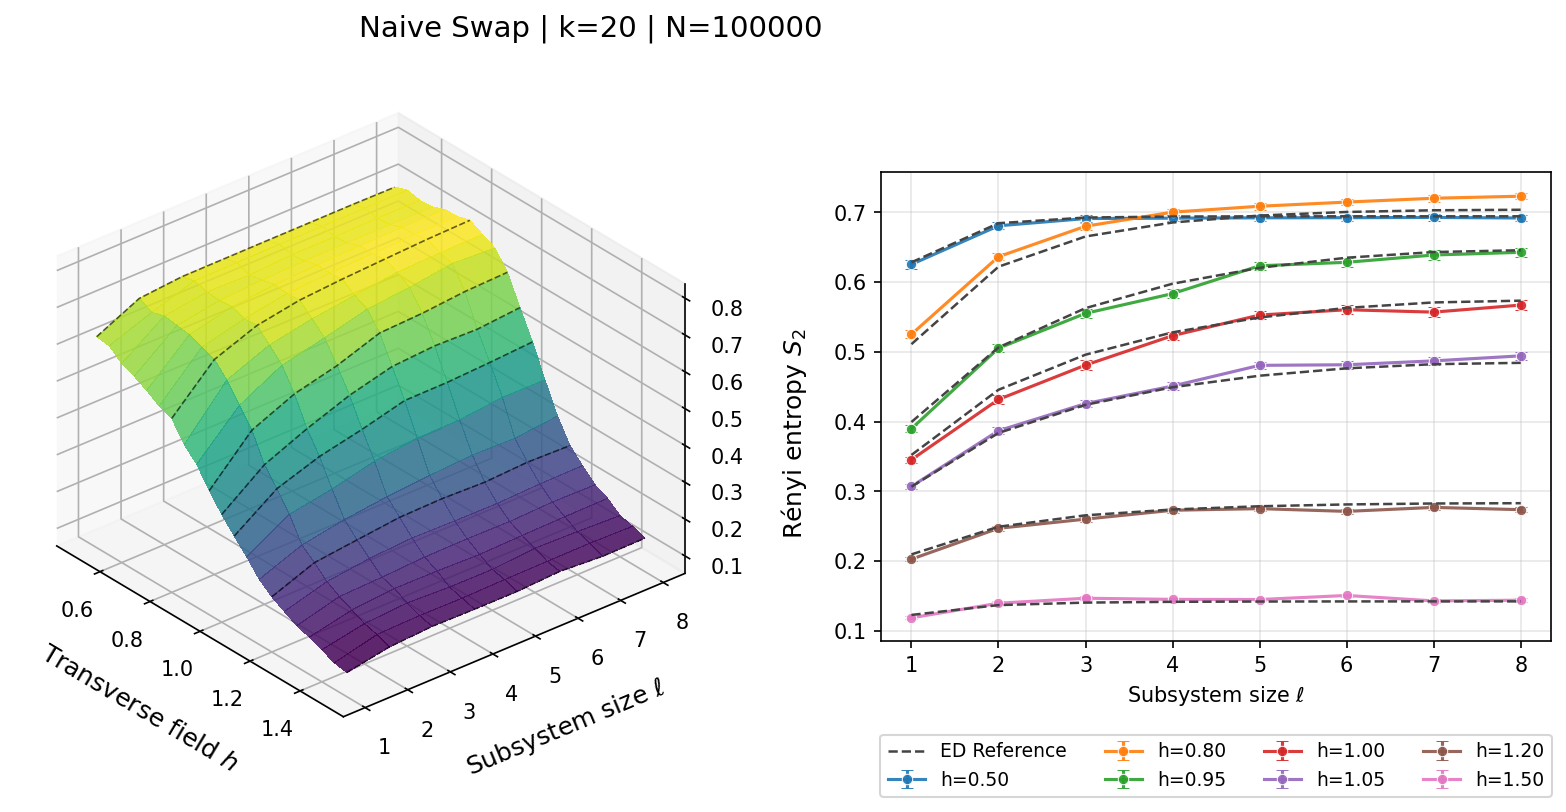

In [21]:
# CONFIGURATION (plot only)
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

MAX_SURF_COLS = 220
MAX_SURF_ROWS = 80
SURF_SHADE    = False

pivot_df = results_df.pivot(index='l', columns='h', values='s2')
pivot_df = pivot_df.sort_index().sort_index(axis=1)

h_dense  = pivot_df.columns.to_numpy(dtype=float)
l_values = pivot_df.index.to_numpy(dtype=float)

X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.to_numpy(dtype=float)

support_h_keys = sorted(results_df[results_df['type'] == 'support']['h'].unique())

fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor('white')

# --- Main Title ---
fig.suptitle(f"Naive Swap | k={ANNEAL_STEPS} | N={TOTAL_SAMPLES}", fontsize=14, y=0.95)

gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# --- 3D ---
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho')

step_c = max(1, X_h.shape[1] // MAX_SURF_COLS)
step_r = max(1, X_h.shape[0] // MAX_SURF_ROWS)

Xr = X_h[::step_r, ::step_c]
Yr = Y_l[::step_r, ::step_c]
Zr = Z_s2[::step_r, ::step_c]

surf = ax3d.plot_surface(
    Xr, Yr, Zr,
    cmap='viridis',
    rstride=1, cstride=1,
    shade=SURF_SHADE,
    linewidth=0,
    antialiased=False,
    alpha=0.85
)

ax3d.set_zlim(np.nanmin(Zr) - 0.05, np.nanmax(Zr) + 0.1)
ax3d.set_xlabel("Transverse field $h$", fontsize=12, labelpad=10)
ax3d.set_ylabel("Subsystem size $\\ell$", fontsize=12, labelpad=10)
ax3d.set_zlabel("Rényi entropy $S_2$", fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)

for h in support_h_keys:
    subset = results_df[results_df['h'] == h].sort_values('l')
    ax3d.plot(
        np.full_like(l_values, float(h), dtype=float),
        l_values,
        subset['s2'].to_numpy(dtype=float),
        color='black', linestyle='--', linewidth=0.8, alpha=0.6, zorder=10
    )

# --- 2D ---
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)
pos = ax2d.get_position()
ax2d.set_position([pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height])

cmap_2d = plt.get_cmap("tab10")

ref_lbl_added = False

for i, h in enumerate(support_h_keys):
    subset = results_df[results_df['h'] == h].sort_values('l')
    s2 = subset['s2'].to_numpy(dtype=float)
    err = subset['s2_err'].to_numpy(dtype=float)
    col = cmap_2d(i % 10)

    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-3)
        if mask.any():
            l_cols = sorted(
                [c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                key=lambda s: int(s[1:])
            )
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values.astype(float)
            x_ref = [int(c[1:]) for c in l_cols]
            lbl = "ED Reference" if not ref_lbl_added else "_nolegend_"
            ax2d.plot(x_ref, y_ref, '--', color='#444444', linewidth=1.2, label=lbl, zorder=5)
            ref_lbl_added = True

    # Updated: Use errorbar instead of plot + fill_between
    ax2d.errorbar(
        l_values, s2,
        yerr=err,
        fmt='o-',             # Format: markers and lines
        color=col,
        markersize=5,
        linewidth=1.5,
        alpha=0.9,
        markeredgecolor='white',
        markeredgewidth=0.5,
        capsize=3,            # Draws the handles (caps) on error bars
        elinewidth=1.5,       # Width of the error bar line
        label=f"h={h:.2f}",
        zorder=4
    )

ax2d.set_xlabel("Subsystem size $\\ell$")
ax2d.legend(frameon=True, fontsize=9, loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, alpha=0.3)

plt.show()